<div style="text-align: center"><span style="font-size: 24px; font-weight: bold;">Data modeling</span></div>

## 1. Phát biểu vấn đề

- Điểm số (Score) của một bộ manga là chỉ số quan trọng giúp đánh giá chất lượng và mức độ yêu thích của cộng đồng độc giả đối với tác phẩm đó. Dự đoán chính xác điểm số của một manga không chỉ giúp người dùng dễ dàng lựa chọn các bộ manga phù hợp với sở thích mà còn hỗ trợ các nhà xuất bản và tác giả tối ưu hóa các chiến lược phát hành và quảng bá. Một điểm số cao có thể là dấu hiệu của một tác phẩm thành công, trong khi một điểm số thấp có thể chỉ ra những yếu tố cần cải thiện.

- Tuy nhiên, việc dự đoán điểm số của manga phụ thuộc vào nhiều yếu tố khác nhau, bao gồm thể loại (Genres), số lượng đánh giá (Vote, Total Review), mức độ phổ biến (Popularity), số lượng người theo dõi (Members), mức độ yêu thích (Favorite), và các yếu tố chất lượng như xếp hạng (Ranked), tình trạng phát hành (Status), cũng như tác giả (Author) và ngày phát hành (Released date). Những yếu tố này có mối quan hệ phức tạp, và việc phân tích mối quan hệ giữa chúng đòi hỏi các phương pháp mô hình hóa mạnh mẽ.

- Mục tiêu của bài toán này là dự đoán điểm số (Score) của một bộ manga dựa trên các đặc trưng trên. Qua đó, ta có thể xác định những yếu tố quan trọng ảnh hưởng đến điểm số của manga, từ đó tối ưu hóa các chiến lược lựa chọn và quảng bá. Việc dự đoán điểm số giúp không chỉ người dùng có thể tìm kiếm các tác phẩm manga chất lượng mà còn hỗ trợ các nhà phát hành trong việc lựa chọn các manga có tiềm năng thành công.

- Để giải quyết bài toán này, các thuật toán học máy như Linear Regression, Decision Tree, và XGBoost sẽ được áp dụng. Các thuật toán này sẽ giúp phân tích các đặc trưng đầu vào và mối quan hệ giữa chúng với điểm số, từ đó dự đoán điểm số một cách chính xác. Việc so sánh hiệu quả của các thuật toán này sẽ cho thấy ưu nhược điểm của từng phương pháp, cũng như giúp xác định phương pháp tối ưu cho bài toán dự đoán.

- Kết quả từ bài toán này không chỉ cung cấp một cơ sở lý thuyết cho việc phân tích và dự đoán điểm số manga mà còn có thể ứng dụng vào các hệ thống gợi ý (recommendation systems). Điều này sẽ góp phần nâng cao trải nghiệm người dùng và giúp tối ưu hóa giá trị thương mại của các bộ manga trên các nền tảng trực tuyến.

## 2. Chuẩn bị dữ liệu

Trước khi tiến hành mô hình hóa, việc lựa chọn các đặc trưng (features) phù hợp là bước quan trọng để đảm bảo tính hiệu quả và độ chính xác của mô hình. 

Đọc tập dữ liệu từ các tập dữ liệu đã được xử lý là `Raw Manga`

In [7]:
import numpy as np
import pandas as pd
manga_df = pd.read_csv('../Preprocessing/Preprocessed Data/Raw Manga/raw_manga_proccessed_updated.csv')

Xem qua một vài dòng của tập dữ liệu

In [9]:
pd.set_option('display.max_columns', None)
manga_df

,Title,Score,Vote,Ranked,Popularity,Members,Favorite,Types,Volumes,Chapters,Status,Genres,Demographic,Serialization,Author,Released date,Completed date,Total Review,Recommended,Mixed Feelings,Not Recommended
0,Berserk,9.47,363720,1,1,725079,130489,Manga,3,16,Publishing,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",Seinen,Young Animal,"[""'Miura,Kentarou'"", ""'Studio Gaga'""]",1989-08-25,Updating,289,252,17,20
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Ru...,9.31,172219,2,23,280428,46269,Manga,24,96,Finished,"[""'Action'"", ""'Adventure'"", ""'Mystery'"", ""'Sup...",Seinen,Ultra Jump,"[""'Araki,Hirohiko'""]",2004-01-19,2011-04-19,131,123,7,1
2,Vagabond,9.26,154583,3,13,406082,44258,Manga,37,327,On Hiatus,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",Seinen,Morning,"[""'Inoue,Takehiko'"", ""'Yoshikawa,Eiji'""]",1998-09-03,2015-05-21,104,93,9,2
3,One Piece,9.22,392811,4,4,642620,119974,Manga,3,16,Publishing,"[""'Action'"", ""'Adventure'"", ""'Fantasy'""]",Shounen,Shounen Jump (Weekly),"[""'Oda,Eiichiro'""]",1997-07-22,Updating,231,190,21,20
4,Monster,9.16,104327,5,29,258581,22008,Manga,18,162,Finished,"[""'Award Winning'"", ""'Drama'"", ""'Mystery'"", ""'...",Seinen,Big Comic Original,"[""'Urasawa,Naoki'""]",1994-12-05,2001-12-20,86,69,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19053,Akihabara Dennou-gumi Patapi!,2.43,501,19994,37132,184,2,Manga,1,11,Finished,"[""'Action'"", ""'Sci-Fi'""]",Shoujo,Nakayoshi,"[""'Kotobuki,Tsukasa'""]",1997-12-29,1998-11-02,0,0,0,0
19054,Jinki,2.43,501,19996,25633,429,0,Manga,4,16,Finished,"[""'Action'"", ""'Drama'"", ""'Supernatural'"", ""'Me...",Shounen,Gangan Wing,"[""'Tsunashima,Shirou'""]",2000-01-26,2001-10-26,0,0,0,0
19055,Magical Nan,2.43,501,19997,35720,203,0,Manga,1,3,Finished,"[""'Comedy'"", ""'Romance'""]",Shoujo,NaN,"[""'Watase,Yuu'""]",1990-01-01,1990-01-01,0,0,0,0
19056,Otenami Haiken!,2.43,501,19998,37133,184,0,Manga,1,2,Finished,"[""'Romance'""]",Shoujo,NaN,"[""'Watase,Yuu'""]",1991-02-01,1991-02-01,0,0,0,0


Với 19058 dòng dữ liệu, bộ dữ liệu này cung cấp một lượng thông tin lớn và đa dạng về các bộ manga, đủ để xây dựng các mô hình học máy hiệu quả. Sự phong phú của các đặc trưng như thể loại, mức độ phổ biến, xếp hạng và số lượng đánh giá giúp tạo ra một tập huấn luyện mạnh mẽ, phản ánh đầy đủ các yếu tố ảnh hưởng đến điểm số của manga. Nhìn chung thì tập dữ liệu có các đặc trưng tương đối là thích hợp để có thể dùng để dự đoán điểm số.

### **2.1 Lựa chọn các đặc trưng**

Để có chất lượng của việc dự đoán là tốt nhất thì sẽ chọn ra những đặc trưng phù hợp nhất và bỏ đi những đặc trưng không cần thiết 
Dưới đây là lý do ngắn gọn hơn cho việc các đặc trưng trên không thích hợp để huấn luyện mô hình dự đoán **Score** của manga:
1. **Title**: Tiêu đề chỉ mang tính chất định danh và không có mối quan hệ rõ ràng với điểm số. Nó không thể cung cấp thông tin định lượng để mô hình học máy sử dụng.

2. **Author**: Tác giả có thể ảnh hưởng đến chất lượng nhưng không phải đặc trưng định lượng. Cần thêm thông tin khác về tác giả để có thể sử dụng hiệu quả.

3. **Released date**: Ngày phát hành không ảnh hưởng trực tiếp đến điểm số của manga và không cung cấp thông tin về chất lượng tác phẩm.

4. **Completed date**: Ngày hoàn thành không liên quan trực tiếp đến điểm số. Thông tin này không đủ mạnh để dự đoán điểm số của manga.

5. **Demographic**: Mặc dù đối tượng độc giả có thể ảnh hưởng đến sự phổ biến, nhưng không có thông tin định lượng rõ ràng cho mô hình học máy.

6. **Serialization**: Nơi xuất bản không cung cấp thông tin trực tiếp về chất lượng của manga và không phải yếu tố dự đoán điểm số.

7. **Ranked**: Xếp hạng là kết quả của các yếu tố khác như điểm số và không phải đặc trưng đầu vào có thể dự đoán điểm số.

In [13]:
df = manga_df.drop(columns=['Title','Author','Released date', 'Completed date', 'Demographic', 'Serialization', 'Ranked']).copy()

Kiểm tra kiểu dữ liệu của các đặc trưng còn lại để xử lí cho phù hợp với mô hình (nếu có)

In [15]:
df.dtypes

Score              float64
Vote                 int64
Popularity           int64
Members              int64
Favorite             int64
Types               object
Volumes              int64
Chapters             int64
Status              object
Genres              object
Total Review         int64
Recommended          int64
Mixed Feelings       int64
Not Recommended      int64
dtype: object

Ta có các đặc trưng `Types`, `Status` là có kiểu dữ liệu là object nên cần phải chuyển hóa lại thành int64. Để làm điều này thì cần xem các giá trị duy nhất của các đặc trưng này để lựa chọn phương pháp mã hóa phù hợp.

In [17]:
# Xem xét các giá trị có trong các cột này để chuyển hóa
print(df['Types'].unique())
print(df['Status'].unique())

['Manga' 'Novel' 'Light Novel' 'Manhua' 'Manhwa' 'One-shot' 'Doujinshi']
['Publishing' 'Finished' 'On Hiatus' 'Discontinued']


Do các đặc trưng này chứa nhiều giá trị thì sẽ chọn phương pháp mã hóa là **LabelEncoder**. Vì LabelEncoder là một phương pháp trong học máy, thường được sử dụng để mã hóa các nhãn (labels) hoặc các giá trị phân loại (categorical values) thành các số nguyên. 

Ví dụ cho đặc trưng `Types`:

**Manga** &rightarrow; 0

**Novel** &rightarrow; 1

**Light** &rightarrow; 2

Và sau khi được mã hóa thì các đặc trưng này sẽ có kiểu dữ liệu là int64, rất thuận tiện và phù hợp cho các mô hình hồi quy

In [19]:
from sklearn.preprocessing import LabelEncoder

# Khởi tạo đối tượng LabelEncoder
label_encoder = LabelEncoder()

# Chuẩn hóa cột 'Types' và Status sang int64
df['Types'] = label_encoder.fit_transform(df['Types'])
df['Status'] = label_encoder.fit_transform(df['Status'])

Bởi vì đây là bài toán hồi quy, nên có thể dùng **correlation matrix** để xác định mức độ tương quan giữa các đặc trưng và biến mục tiêu. Các đặc trưng có mối quan hệ mạnh với biến mục tiêu sẽ giúp mô hình dự đoán chính xác hơn, trong khi những đặc trưng có mối tương quan yếu có thể không cung cấp thông tin quan trọng. Bằng cách loại bỏ các đặc trưng không có sự liên kết mạnh với biến mục tiêu, chúng ta không chỉ giảm thiểu độ phức tạp mà còn giúp mô hình tập trung vào các yếu tố quan trọng, cải thiện khả năng dự đoán và giảm nguy cơ **overfitting**.

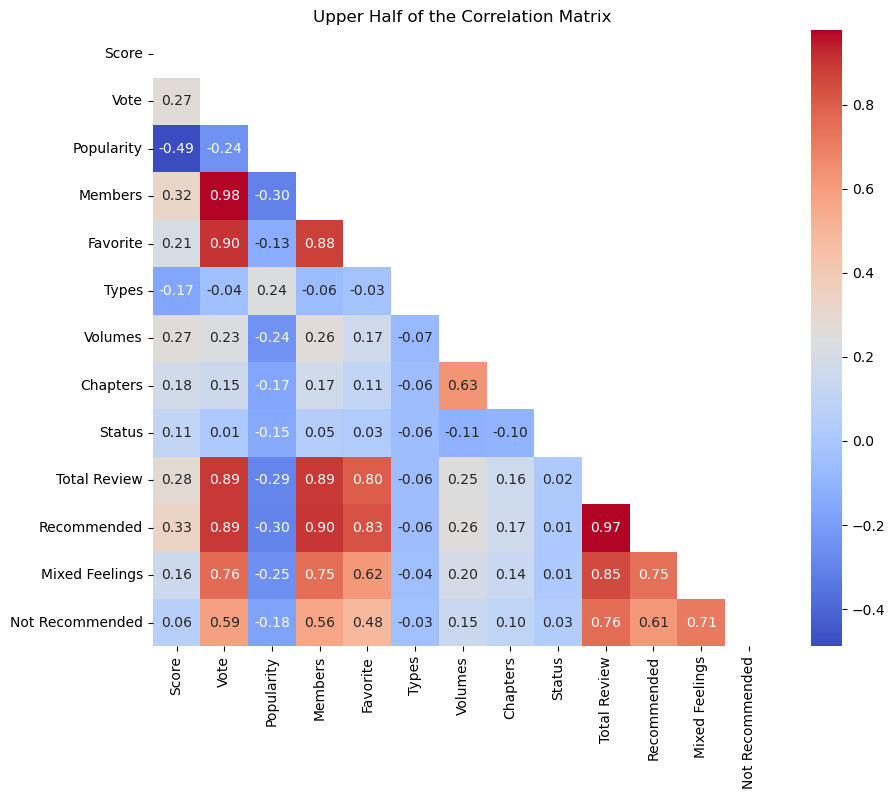

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df.select_dtypes(include=['number'])

# Tính ma trận tương quan
correlation_matrix = numeric_df.corr()

# Lọc nửa trên của ma trận tương quan (chỉ hiển thị phần đối xứng trên)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Vẽ ma trận tương quan với nửa trên
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Upper Half of the Correlation Matrix')
plt.show()

Nhìn vào ma trận tương quan trên thì sẽ xóa những đặc trưng có mối tương quan thấp với mức độ phổ biến **< 0.2**

In [23]:
df.drop(columns=['Types','Chapters','Status','Mixed Feelings','Not Recommended'], inplace=True)
df.head(3)

,Score,Vote,Popularity,Members,Favorite,Volumes,Genres,Total Review,Recommended
0,9.47,363720,1,725079,130489,3,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",289,252
1,9.31,172219,23,280428,46269,24,"[""'Action'"", ""'Adventure'"", ""'Mystery'"", ""'Sup...",131,123
2,9.26,154583,13,406082,44258,37,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",104,93


Do đặc trưng `Genres` là một thuộc tính ảnh hưởng khá nhiều đến quan trọng nên cần mã hóa cột này với phương pháp **MultiLabelBinarizer**. Là mỗi thể loại sẽ tạo ra một đặc trưng riêng với thể loại đó cho biết là một bộ manga có hay không có thể loại đó

In [25]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer

# Chuyển đổi mảng 'Genres' thành danh sách các chuỗi
df['Genres'] = df['Genres'].apply(ast.literal_eval)

# Khởi tạo đối tượng MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Mã hóa đặc trưng 'Genres'
genres_encoded = pd.DataFrame(mlb.fit_transform(df['Genres']), columns=mlb.classes_, index=df.index)

# Nối các đặc trưng mới vào dataframe đang xử lí
df = pd.concat([df, genres_encoded], axis=1).drop(columns=['Genres'])
df

,Score,Vote,Popularity,Members,Favorite,Volumes,Total Review,Recommended,'Action','Adult Cast','Adventure','Anthropomorphic','Avant Garde','Award Winning','Boys Love','CGDCT','Childcare','Combat Sports','Comedy','Crossdressing','Delinquents','Detective','Drama','Ecchi','Educational','Fantasy','Gag Humor','Girls Love','Gore','Gourmet','Harem','High Stakes Game','Historical','Horror','Idols (Female)','Idols (Male)','Isekai','Iyashikei','Love Polygon','Love Status Quo','Magical Sex Shift','Mahou Shoujo','Martial Arts','Mecha','Medical','Memoir','Military','Music','Mystery','Mythology','Organized Crime','Otaku Culture','Parody','Performing Arts','Pets','Psychological','Racing','Reincarnation','Reverse Harem','Romance','Samurai','School','Sci-Fi','Showbiz','Slice of Life','Space','Sports','Strategy Game','Super Power','Supernatural','Survival','Suspense','Team Sports','Time Travel','Urban Fantasy','Vampire','Video Game','Villainess','Visual Arts','Workplace'
0,9.47,363720,1,725079,130489,3,289,252,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,9.31,172219,23,280428,46269,24,131,123,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,9.26,154583,13,406082,44258,37,104,93,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9.22,392811,4,642620,119974,3,231,190,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9.16,104327,29,258581,22008,18,86,69,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19053,2.43,501,37132,184,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19054,2.43,501,25633,429,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
19055,2.43,501,35720,203,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19056,2.43,501,37133,184,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **2.2 Chia dữ liệu**

Trong bước này sẽ chia dữ liệu theo các bước sau:
- Xác định biến mục tiêu và các biến đặc trưng
- Chia dữ liệu ban đầu thành các tập huấn luyện, kiểm tra, xác thực với tỷ lệ **70:15:15**
- Chuẩn hóa dữ liệu bằng cách sử dụng MinMaxScaler

$$
x_{\text{scaled}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}
$$

In [28]:
from sklearn.model_selection import train_test_split, KFold, learning_curve
from sklearn.preprocessing import MinMaxScaler

features = df.drop(columns=['Score']).columns.to_list()
target = 'Score'

# Chia ra các tập dữ liệu (70% train, 30% còn lại -> 15% test, 15% validation)
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=1/2, random_state=42)

# Chia dữ liệu cho các tập
X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]
X_val, y_val = val_data[features], val_data[target]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

X_train shape: (13340, 79)
y_train shape: (13340,)
X_test shape: (2859, 79)
y_test shape: (2859,)
X_val shape: (2859, 79)
y_val shape: (2859,)


## 3. Tạo, huấn luyện và kiểm tra mô hình

### **Mô hình**

Để giải quyết vấn đề này thì sẽ dùng các mô hình học máy như:
- **Linear Regression**: Dùng để dự đoán khi mối quan hệ giữa các biến là tuyến tính, dễ triển khai nhưng hạn chế với dữ liệu phức tạp.
- **Random Forest**: Hiệu quả cho dữ liệu phi tuyến tính, kháng overfitting tốt, nhưng có thể chậm với dữ liệu lớn.
- **XGBoost**: Mạnh mẽ, tối ưu với dữ liệu không đồng nhất, phù hợp với các bài toán phức tạp nhưng cần tinh chỉnh hyperparameter kỹ lưỡng.

Để thuận tiện khi so sánh giữa các thuật toán hoặc báo cáo kết quả. Cần tạo ra biến để kiểm soát tính **ngẫu nhiên** trong quá trình huấn luyện hoặc xây dựng mô hình. Đảm bảo rằng kết quả của mô hình có thể được **tái lập** trong các lần chạy khác nhau

In [33]:
random_state = 42

Tạo ra 3 mô hình huấn luyện trong biến `models` được thêm các tham số vào sao cho có thể chạy được tốt nhất và ổn định với:
- `n_jobs`: để xác định số lượng luồng (threads) CPU sẽ được sử dụng để huấn luyện hoặc dự đoán. Việc gán `n_jobs=-1` có nghĩa là sẽ sử dụng **tất cả các luồng CPU** có sẵn trên máy tính để chạy. Do XGBoost và Random Forest đều thực hiện tính toán song song để tăng tốc huấn luyện và dự đoán nên dây là lựa chọn tối ưu để tận dụng tối đa tài nguyên phần cứng
- `random_state`: để các mô hình Random Forest và XGBoost sẽ chạy ra cùng một kết quả khi chạy lại với cùng dữ liệu

In [35]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(n_jobs=-1, random_state=random_state),
    'Random Forest': RandomForestRegressor(n_jobs=-1, random_state=random_state)
}

### **Thước đo để đánh giá mô hình**

Bài toán là dự đoán mức độ phổ biến (Popularity) của các thể loại manga là một bài toán hồi quy, cho nên sẽ dùng những thước đo phù hợp để đánh giá mô hình
- **Mean Squared Error (MSE)**
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

- **Mean Absolute Error (MAE)**

$$
\text{MAE} =  \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

- **R-squared ($R^2$) Score**
$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y}_i)^2}
$$
Trong đó:
- n: Số lượng mẫu dữ liệu
- $y_i$: Giá trị thực tế của mẫu thứ i
- $\hat{y}_i$: Giá trị dự đoán của mẫu thứ i
- $\bar{y}_i$:  Giá trị trung bình của biến phụ thuộc

Tạo ra hàm `evaluate_model` để đánh giá mô hình dựa trên các thước đo như trên

In [39]:
def evaluate_model(y_true, y_pred):
    """
    Tính toán các tiêu chí đánh giá MSE, MAE, R2 score.
    Args:
        y_true (array-like): Giá trị thực của mục tiêu.
        y_pred (array-like): Giá trị dự đoán từ mô hình.
    Returns:
        dict: Từ điển chứa MSE, MAE, và R2 score.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "MAE": mae, "R2": r2}

### **Huấn luyện mô hình trên tập huấn luyện**

#### 1. Tạo ra hàm `train_and_evaluate_model` để huấn luyện và đánh giá kết quả cho từng loại mô hình huấn luyện

In [42]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Huấn luyện mô hình và trả về mô hình đã huấn luyện cùng với kết quả đánh giá.
    Args:
        model: Mô hình cần huấn luyện.
        X_train, y_train: Dữ liệu huấn luyện.
        X_val, y_val: Dữ liệu xác thực.
        X_test, y_test: Dữ liệu kiểm tra.
    Returns:
        tuple: (Mô hình đã huấn luyện, kết quả đánh giá).
    """
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    
    # Dự đoán trên validation và test
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_test)

    # Đánh giá hiệu suất
    train_metrics = evaluate_model(y_train, train_preds) 
    val_metrics = evaluate_model(y_val, val_preds)
    test_metrics = evaluate_model(y_test, test_preds)
    
    # Trả về mô hình đã huấn luyện và kết quả đánh giá
    return model, {
        "Train": train_metrics,
        "Validation": val_metrics,
        "Test": test_metrics
    }

#### 2. Huấn luyện cho từng mô hình

Có tạo ra các biến để lưu trữ mô hình và kết quả đã huấn luyện như `trained_models` và `evaluation_models` để có thể tái sử dụng như trực quan hóa biểu đồ so sánh giữa các mô hình, giữa các mô hình này với các mô hình được cải tiến

In [45]:
trained_models = {}  # Lưu các mô hình đã huấn luyện
evaluation_models = {}  # Lưu kết quả đánh giá

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    trained_model, evaluation = train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
    trained_models[model_name] = trained_model
    evaluation_models[model_name] = evaluation

Training and evaluating Linear Regression...
Training and evaluating XGBoost...
Training and evaluating Random Forest...


#### 3. Kiểm tra kết quả đánh giá

Tạo bảng số liệu cung cấp cái nhìn tổng quan về các thước đo trên các tập dữ liệu

In [48]:
data = {}
data['Linear Regression'] = {}
data['XGBoost'] = {}
data['Random Forest'] = {}
for col in data.keys():
    for dataset_name in ['Train','Validation','Test']:
        data[col][dataset_name] = []
        for metric in ['MSE','MAE','R2']:
            data[col][dataset_name].append(f'{metric}:{round(evaluation_models[col][dataset_name][metric],2)}')

# Tạo DataFrame từ danh sách
dff = pd.DataFrame(data)

pd.set_option('display.max_colwidth', None)  # Hiển thị đầy đủ nội dung trong mỗi ô
dff

,Linear Regression,XGBoost,Random Forest
Train,"[MSE:0.21, MAE:0.33, R2:0.43]","[MSE:0.06, MAE:0.18, R2:0.84]","[MSE:0.02, MAE:0.1, R2:0.95]"
Validation,"[MSE:0.23, MAE:0.33, R2:0.39]","[MSE:0.11, MAE:0.25, R2:0.71]","[MSE:0.12, MAE:0.26, R2:0.68]"
Test,"[MSE:0.24, MAE:0.34, R2:0.41]","[MSE:0.12, MAE:0.26, R2:0.71]","[MSE:0.12, MAE:0.27, R2:0.69]"


#### 4. Trực quan hóa kết quả

Tạo ra hàm `plot_metrics` để trực quan hóa các tiêu chí thước đo cho các tập **train** và **test**

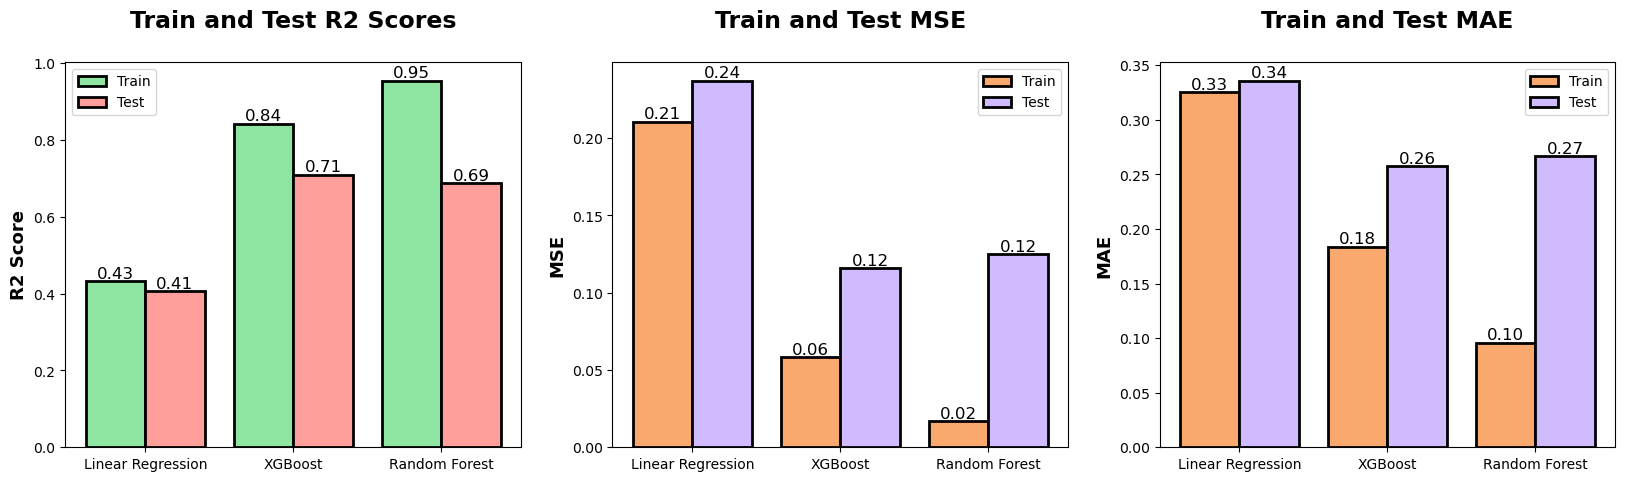

In [51]:
def plot_metrics(evaluation):
    """
    Hàm vẽ đồ thị cho các chỉ số hiệu suất của mô hình trên các tập train, validation, và test.
    Args:
        metrics (dict): Từ điển chứa các chỉ số hiệu suất, gồm 'Train', 'Validation', và 'Test' cho mỗi chỉ số.
        model_name (str): Tên mô hình, dùng để đặt tiêu đề đồ thị.
    """
    categories = evaluation.keys()
    train_r2 = [evaluation[category]['Train']['R2'] for category in categories]
    test_r2 = [evaluation[category]['Test']['R2'] for category in categories]
    train_mse = [evaluation[category]['Train']['MSE'] for category in categories]
    test_mse = [evaluation[category]['Test']['MSE'] for category in categories]
    train_mae = [evaluation[category]['Train']['MAE'] for category in categories]
    test_mae = [evaluation[category]['Test']['MAE'] for category in categories]
    
    indices = np.arange(len(categories))
    # sns.set_style("darkgrid")
    #sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    bars1_train = ax[0].bar(indices - 0.2, train_r2, width=0.4, label='Train', color='#8de5a1', linewidth=2, edgecolor='k')
    bars1_test = ax[0].bar(indices + 0.2, test_r2, width=0.4, label='Test', color='#ff9f9b', linewidth=2, edgecolor='k')
    ax[0].set_ylabel('R2 Score', fontsize=13, weight='bold')
    ax[0].set_xticks(indices)
    ax[0].set_xticklabels(categories)
    ax[0].set_title('Train and Test R2 Scores\n', fontsize=17, weight ='bold')
    ax[0].legend()
    ax[0].bar_label(bars1_train, fmt='%.2f', fontsize=12, color='black')
    ax[0].bar_label(bars1_test, fmt='%.2f', fontsize=12, color='black')
    
    # Bar chart for MSE
    bars2_train = ax[1].bar(indices - 0.2, train_mse, width=0.4, label='Train', color='#faa96e', linewidth=2, edgecolor='k')
    bars2_test = ax[1].bar(indices + 0.2, test_mse, width=0.4, label='Test', color='#d0bbff',  linewidth=2, edgecolor='k')
    ax[1].set_xticks(indices)
    ax[1].set_ylabel('MSE', fontsize=13, weight='bold')
    ax[1].set_xticklabels(categories)
    ax[1].set_title('Train and Test MSE\n', fontsize=17, weight ='bold')
    ax[1].legend()
    
    ax[1].bar_label(bars2_train, fmt='%.2f', fontsize=12, color='black')
    ax[1].bar_label(bars2_test, fmt='%.2f', fontsize=12, color='black')

    # Bart chart for MAE
    bars3_train = ax[2].bar(indices - 0.2, train_mae, width=0.4, label='Train', color='#faa96e', linewidth=2, edgecolor='k')
    bars3_test = ax[2].bar(indices + 0.2, test_mae, width=0.4, label='Test', color='#d0bbff', linewidth=2, edgecolor='k')
    ax[2].set_ylabel('MAE', fontsize=13, weight='bold')
    ax[2].set_xticks(indices)
    ax[2].set_xticklabels(categories)
    ax[2].set_title('Train and Test MAE\n', fontsize=17, weight ='bold')
    ax[2].legend()
    
    ax[2].bar_label(bars3_train, fmt='%.2f', fontsize=12, color='black')
    ax[2].bar_label(bars3_test, fmt='%.2f', fontsize=12, color='black')
    
    plt.show()

plot_metrics(evaluation_models)

### **Nhận xét**
Dựa trên các biểu đồ được trình bày, ta có thể rút ra một số nhận xét như sau:

#### **Điểm số R2**
- Mô hình XGBoost cho kết quả tốt nhất trên cả tập train và tập test, chỉ ra khả năng dự đoán của mô hình này là tốt nhất. 
- Mô hình Random Forest cũng thể hiện hiệu suất tốt, với điểm số R2 tương đối cao trên cả hai tập dữ liệu. Khă năng là mô hình này bị overfitting do dự đoán trên tập Train là 0.95 nhưng trên tập Test là 0.69 khá là chênh lệch
- Mô hình Hồi quy Tuyến tính có điểm số R2 thấp nhất trên cả tập train và tập test, gợi ý rằng mô hình này có thể không phù hợp nhất với bài toán này.

#### **Sai số Trung Bình Bình Phương (MSE)**
- Các giá trị MSE nhìn chung đều thấp, trong đó mô hình XGBoost có MSE thấp nhất trên cả tập train và tập test.
- Mô hình Random Forest cũng thể hiện hiệu suất tốt, với MSE trên tập Train là thấp nhất 0.02 nhưng trên tập Test lại cao hơn cả mô hình XGBoost. Điều này càng góp phần minh chứng cho việc mô hình Random Forest bị overfitting
- Mô hình hồi quy tuyến tính có MSE cao nhất, cho thấy mô hình này có sai số dự đoán lớn nhất. 

#### **Sai số Tuyệt Đối Trung Bình (MAE)**
- Các giá trị MAE cũng đều ở mức thấp, với mô hình XGBoost có MAE thấp nhất trên tập test.
- Mô hình Random Forest và hồi quy tuyến tính có MAE cao hơn so với XGBoost, nhưng vẫn ở mức tương đối thấp.

Tổng quát, các biểu đồ cho thấy mô hình XGBoost là tốt nhất về cả ba tiêu chí, trên cả tập train và tập test. Mô hình Random Forest thể hiện rõ việc bị overfitting và cần điều chỉnh lại, trong khi mô hình hồi quy tuyến tính là kém nhất trong số ba mô hình này.

## 4. Quá trình học tập của mô hình
- Dựa trên các kết quả phân tích trước đó, rõ ràng mô hình XGBoost đang cho thấy hiệu suất tốt nhất. Tuy nhiên, để có thể đưa ra kết luận chắc chắn hơn, chúng ta có thể tiếp tục kiểm tra đường cong học tập (learning curve) của các mô hình.

- Đường cong học tập là một công cụ quan trọng giúp chúng ta hiểu rõ hơn về quá trình học của các mô hình máy học. Nó cho phép chúng ta đánh giá xem mô hình có xu hướng học tập hay không, liệu nó có bị quá khớp (overfitting) hay không, và từ đó có thể đưa ra các điều chỉnh phù hợp.

- Hãy cùng sử dụng hàm `plot_learning_curve()` để vẽ đường cong học tập cho các mô hình. Việc này sẽ giúp chúng ta có cái nhìn toàn diện hơn về hiệu suất của các mô hình trong quá trình huấn luyện và kiểm tra.

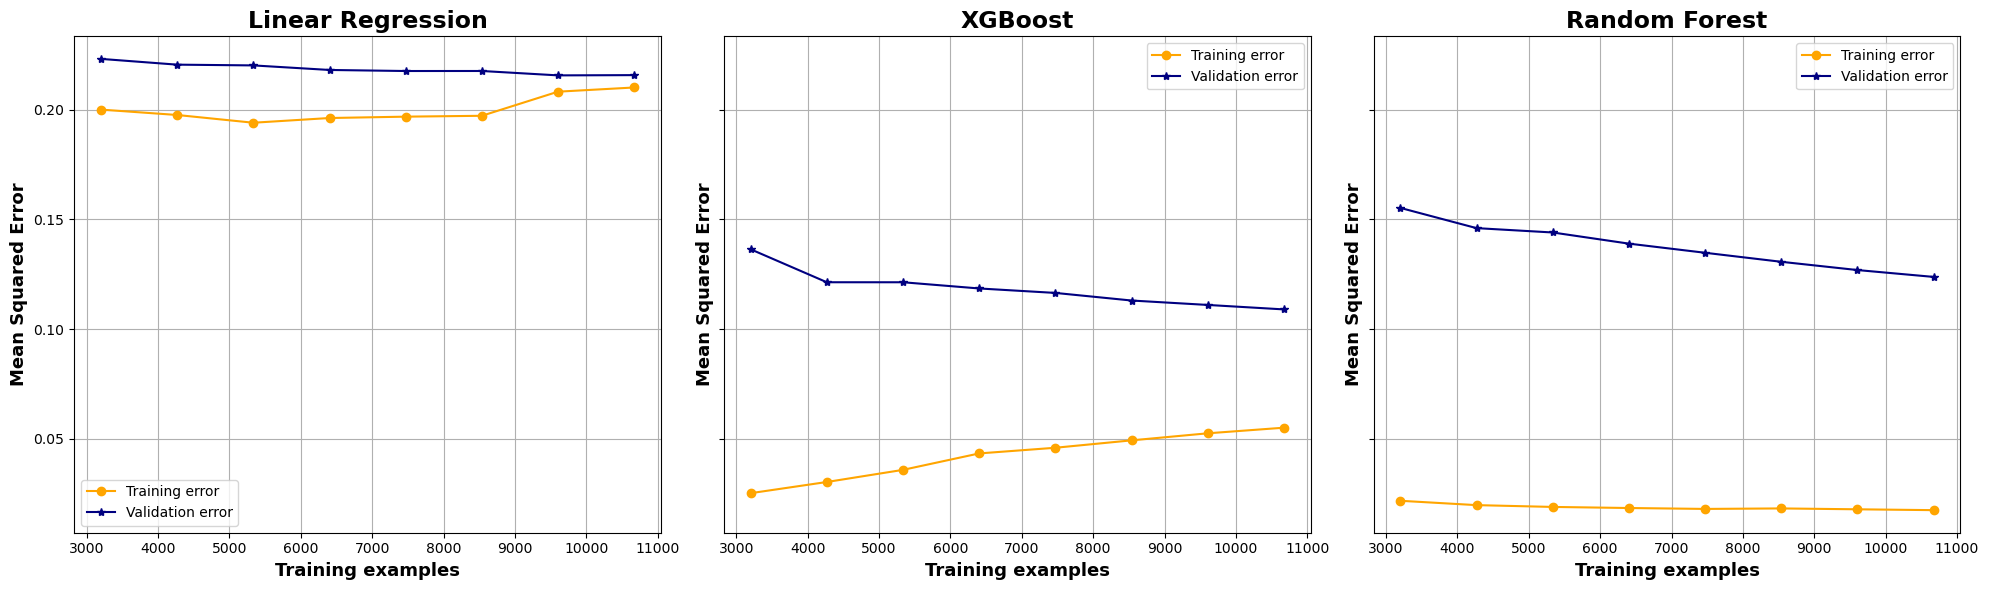

In [54]:
# Hàm vẽ đồ thị learning curve cho một mô hình
def plot_learning_curve(model, X, y, ax, title):
    # Tính toán learning curve với cross-validation (cv=5) và tính toán MSE (negative)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.3, 1.0, 8)
    )

    # Tính toán giá trị trung bình của lỗi trên tập huấn luyện và kiểm tra
    train_scores_mean = -np.mean(train_scores, axis=1)  # Chuyển lỗi âm thành dương
    val_scores_mean = -np.mean(val_scores, axis=1)      # Chuyển lỗi âm thành dương

    # Vẽ đường lỗi trên tập huấn luyện
    ax.plot(train_sizes, train_scores_mean, label='Training error', color='orange', marker='o')
    # Vẽ đường lỗi trên tập kiểm tra (validation)
    ax.plot(train_sizes, val_scores_mean, label='Validation error', color='navy', marker='*')

    # Thiết lập tiêu đề đồ thị với phông chữ và độ đậm
    ax.set_title(title, fontsize=17, fontweight='bold')
    ax.set_xlabel('Training examples', fontsize=13, weight='bold')
    ax.set_ylabel('Mean Squared Error', fontsize=13, weight='bold')
    # Thêm chú thích cho các đường trên đồ thị
    ax.legend()
    # Bật lưới cho đồ thị để dễ quan sát
    ax.grid(True)

# Tạo các subplots để vẽ nhiều đồ thị con
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Vòng lặp qua các mô hình trong dictionary 'models', vẽ đồ thị cho mỗi mô hình
for (model_name, model), ax in zip(models.items(), axes):
    plot_learning_curve(model, X_train, y_train, ax, model_name)  # Gọi hàm vẽ đồ thị với tên mô hình

# Điều chỉnh các subplot sao cho chúng không bị chồng lên nhau
plt.tight_layout()
# Hiển thị tất cả các đồ thị đã vẽ
plt.show()


Dựa trên các đường cong học tập (learning curve) của ba mô hình - Hồi quy tuyến tính, XGBoost và Random Forest, ta có thể rút ra một số nhận xét sau:

#### **Hồi quy tuyến tính**
- Đường cong lỗi training và validation khá gần nhau, cho thấy mô hình này không bị quá khớp.
- Tuy nhiên, mức lỗi tương đối cao hơn so với hai mô hình còn lại, gợi ý rằng mô hình Hồi quy tuyến tính có thể không phải là lựa chọn tối ưu nhất cho bài toán này.

#### **XGBoost**
- Đường cong lỗi training liên tục giảm khi số lượng mẫu training tăng lên, trong khi đường cong lỗi validation ban đầu giảm và sau đó bắt đầu ổn định.
- Khoảng cách giữa đường cong training và validation nhỏ, cho thấy mô hình không bị quá khớp đáng kể.
- Mức lỗi tổng thể thấp hơn so với mô hình hồi quy tuyến tính, chỉ ra rằng XGBoost đang thể hiện hiệu suất tốt hơn.

#### **Random Forest**
- Cả đường cong lỗi training và validation đều giảm đều khi số lượng mẫu training tăng.
- Khoảng cách giữa đường cong training và validation nhỏ, cho thấy mô hình bị quá khớp.
- Mức lỗi hơi cao hơn so với XGBoost, nhưng vẫn thấp hơn so với mô hình Hồi quy Tuyến tính.

Tóm lại, mô hình XGBoost có đường cong học tập tốt nhất, với lỗi training và validation thấp và ổn định, gợi ý rằng đây là mô hình phù hợp nhất với bài toán trong số ba mô hình. Mô hình Random Forest cũng thể hiện hiệu suất tốt, trong khi mô hình Hồi quy Tuyến tính là kém nhất.

## 5. Tinh chỉnh mô hình trên tập xác thực

Dựa trên các đường cong học tập (learning curve) của ba mô hình, có thể thấy rằng việc tinh chỉnh các tham số sẽ rất hữu ích để cải thiện hiệu suất của các mô hình.

### Hồi quy tuyến tính (Linear Regression)

Đối với mô hình hồi quy tuyến tính, mặc dù không bị quá khớp (overfitting), nhưng lỗi vẫn tương đối cao so với các mô hình khác. Để cải thiện hiệu suất, chúng ta có thể thử:

- **Điều chỉnh tham số `fit_intercept`** để xác định liệu có cần tính toán hằng số (intercept) trong mô hình hay không. Việc này có thể giúp giảm độ lỗi nếu dữ liệu không có intercept tự nhiên.
  
### XGBoost

Với mô hình XGBoost, đường cong học tập rất tốt, cho thấy mô hình này đang hoạt động hiệu quả. Tuy nhiên, vẫn có thể thử:

- **Điều chỉnh các tham số**:
  - `learning_rate`: Thử nghiệm với các giá trị như 0.01, 0.1, 0.2 để kiểm tra tốc độ học của mô hình. Giá trị nhỏ giúp mô hình học chậm nhưng chính xác hơn.
  - `n_estimators`: Tăng hoặc giảm số lượng cây quyết định để tìm ra số cây tối ưu. Thử với 100, 200, hoặc 300 cây để kiểm tra hiệu quả.
  - `max_depth`: Thử các độ sâu khác nhau (3, 6, 9) để xem mô hình có thể học được mối quan hệ phức tạp hơn mà không bị overfit.

### Random Forest

Mô hình Random Forest cũng cho kết quả khá tốt, nhưng lại bị overfitting do đó có thể cải thiện thêm bằng cách:

- **Điều chỉnh số lượng cây quyết định** `n_estimators`: Thử nghiệm với các giá trị như 100, 200, và 300 cây để tìm số cây tối ưu giúp giảm bias mà không làm tăng độ phức tạp tính toán quá mức.
  
- **Thay đổi độ sâu tối đa của các cây** `max_depth`: Kiểm tra với các giá trị khác nhau (None, 5, 10, 15) để tìm ra độ sâu thích hợp. Độ sâu quá lớn có thể dẫn đến overfitting, trong khi độ sâu quá nhỏ có thể khiến mô hình không học đủ thông tin từ dữ liệu.

- **Điều chỉnh tham số** `min_samples_split`: Điều chỉnh số lượng mẫu tối thiểu để chia một node. Kiểm tra các giá trị như 2, 5, 10 để tránh việc cây học quá chi tiết.

Những điều chỉnh này giúp tối ưu hóa các mô hình, cải thiện khả năng dự đoán và giảm thiểu lỗi.

Bằng cách thử nghiệm và fine-tuning các tham số khác nhau của từng mô hình, chúng ta có thể tìm ra cấu hình tối ưu nhất, cải thiện đáng kể hiệu suất của các mô hình trên tập dữ liệu này.

In [58]:
# Định nghĩa các grid tham số cho từng mô hình
param_grids = {
    'Linear Regression': {
        # Không có nhiều tham số để tinh chỉnh cho Linear Regression
        'fit_intercept': [True, False]
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
}

Sau đó cần thiết kế hàm `tune_model` để tìm các tham số tốt nhất

In [60]:
from sklearn.model_selection import GridSearchCV

def tune_model(model, param_grid, X_train, y_train, X_val, y_val):
    # Thiết lập GridSearchCV
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Dự đoán với các tham số tốt nhất
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    
    # Đánh giá mô hình
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    return {
        'best_model': best_model,
        'best_params': grid_search.best_params_,
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

Thực hiện việc tinh chỉnh cho từng mô hình:

In [62]:
# Từ điển để lưu kết quả
tuning_results = {}

# Thực hiện fine-tune cho từng mô hình
for model_name, model in models.items():
    tuning_results[model_name] = tune_model(
        model, 
        param_grids[model_name], 
        X_train, y_train, 
        X_val, y_val
    )

/home/bonz/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Trực quan hóa kết quả khi tìm được các mô hình tốt nhất

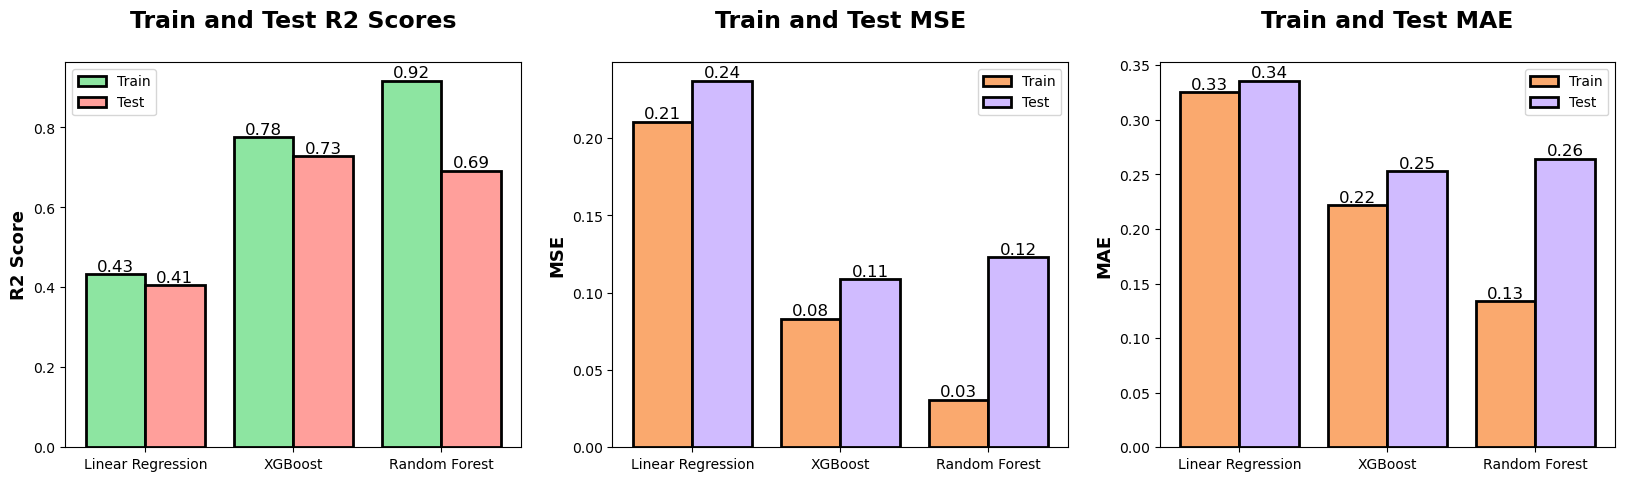

In [64]:
for model_name, model in tuning_results.items():
    trained_model, evaluation = train_and_evaluate_model(model['best_model'], X_train, y_train, X_val, y_val, X_test, y_test)
    trained_models[model_name] = trained_model
    evaluation_models[model_name] = evaluation
plot_metrics(evaluation_models)

- Nhìn chung, các mô hình sau khi được tinh chỉnh để tìm ra các tham số tối ưu nhất thì hoàn toàn thấy được là giảm được rõ ràng độ overfitting của từng mô hình. Với các tiêu chí đánh giá trên các mô hình trên tập huấn luyện đều giảm và đều tăng theo hướng có lợi trên tập test giúp cho các mô hình có thể dự đoán tốt hơn

- Dựa trên các thước đo thì mô hình XGBoost cho ra kết quả trên tập train tốt nhất so với các mô hình còn lại. Do đó đây là mô hình tốt nhất để có thể giải quyết bài toán dự đoán `Score` của các bộ manga  

### Hãy xem 10 dòng ngẫu nhiên từ tập test và so sánh `Score` với dự đoán của các mô hình

In [66]:
df = pd.DataFrame({
    'Actual': y_test,
    'Linear Regression': tuning_results['Linear Regression']['best_model'].predict(X_test),
    'XGBoost': tuning_results['XGBoost']['best_model'].predict(X_test),
    'Random Forest': tuning_results['Random Forest']['best_model'].predict(X_test)
})
df.sample(10)

,Actual,Linear Regression,XGBoost,Random Forest
7511,7.07,7.002129,6.863778,6.932598
13884,6.63,6.750149,7.089479,6.951584
6872,7.12,7.065669,6.988448,6.882450
1321,7.79,7.509638,7.840215,7.793967
7268,7.09,6.975453,6.908566,7.000647
2699,7.53,7.187999,7.531432,7.391934
5441,7.23,7.279478,7.565786,7.455922
5836,7.20,6.872225,6.926577,7.001394
17113,6.31,6.446247,6.453261,6.643039
17595,6.22,6.818051,6.767607,6.661355
